In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, LeakyReLU
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

In [0]:
EPOCHS = 25
BATCH_SIZE = 32
INIT_LR = 0.0001

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
from sklearn.preprocessing import OneHotEncoder

one = OneHotEncoder()
y = one.fit_transform(y_test.reshape((-1,1))).toarray()
print(y)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
print(y)
print(y_test)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[7 2 1 ... 4 5 6]


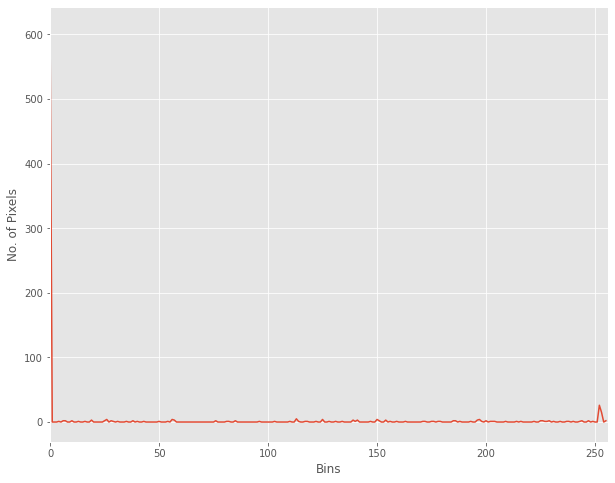

In [0]:
import cv2
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

c = np.reshape(x_test, (10000, 784))

hist = cv2.calcHist([c[11]], [0], None, [256], [0, 256])
plt.xlabel("Bins")
plt.ylabel("No. of Pixels")
plt.plot(hist)
plt.xlim([0, 256])
plt.savefig('./hist.png')
plt.show()

In [0]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

c = np.reshape(x_train, (60000, 784))
c = c / 255.0

pca = PCA(2)
proj = pca.fit_transform(c)
r = plt.scatter(proj[:30000, 0], proj[:30000, 1],c=y_train[:30000], s=8, cmap='inferno')
plt.xlabel('1st Principal')
plt.ylabel('2nd Principal')
plt.colorbar()
plt.savefig('./train_vis.png')
plt.show()

In [0]:
c_train = np.reshape(x_train, (60000, 784))
print(c_train.shape)

(60000, 784)


In [0]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [0]:
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [0]:
x_train_noise = np.random.normal(loc=0.0, scale=0.5, size=x_train.shape)
x_test_noise = np.random.normal(loc=0.0, scale=0.5, size=x_test.shape)
x_train_noisy = np.clip(x_train + x_train_noise, 0, 1)
x_test_noisy = np.clip(x_test + x_test_noise, 0, 1)

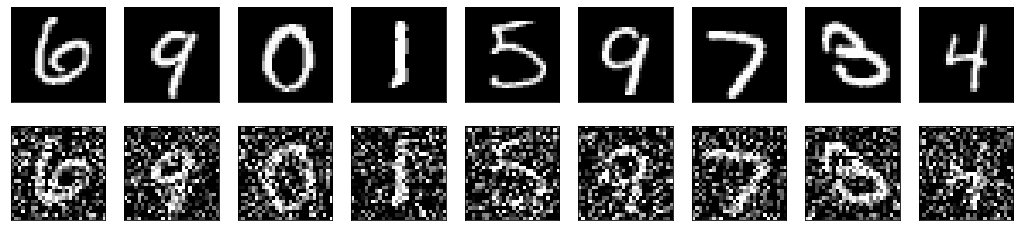

In [0]:
n = 10
x = 10
plt.figure(figsize=(20, 4))

for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i+x].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_noisy[i+x].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
def build_model(height, width, depth, filters=(32, 64), latent_dim=128, chan_dim=-1):
  inputs = Input(shape=(height, width, depth))
  x = inputs

  for f in filters:
    x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=chan_dim)(x)

  volume_size = K.int_shape(x)
  x = Flatten()(x)
  latent = Dense(latent_dim)(x)
  encoder = Model(inputs, latent, name="encoder")

  latent_inputs = Input(shape=(latent_dim,))
  x = Dense(np.prod(volume_size[1:]))(latent_inputs)
  x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)

  for f in filters[::-1]:
    x = Conv2D(f, (3, 3), padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=chan_dim)(x)

  outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  decoder = Model(latent_inputs, outputs, name="decoder")

  autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
  return autoencoder, encoder, decoder

In [0]:
def acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def r_square(y_true, y_pred):
  SS_res =  K.sum(K.square(y_true - y_pred)) 
  SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [0]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (
  RootMeanSquaredError,
) 

opt = Adam(lr=0.0001, amsgrad=True)
autoencoder, encoder, decoder = build_model(28,28,1)
autoencoder.compile(
    loss="mse",
    optimizer=opt,
    metrics=[
      acc,
      'mae',
      RootMeanSquaredError(),
      r_square,
])

r = autoencoder.fit(
  x_train_noisy,
  x_train,
  validation_data=(x_test_noisy, x_test),
  epochs=25,
  batch_size=32
)

Epoch 1/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0492 - acc: 0.9246 - mae: 0.1207 - root_mean_squared_error: 0.2217 - r_square: 0.4800 - val_loss: 0.0210 - val_acc: 0.9550 - val_mae: 0.0687 - val_root_mean_squared_error: 0.1449 - val_r_square: 0.7770
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0168 - acc: 0.9596 - mae: 0.0602 - root_mean_squared_error: 0.1297 - r_square: 0.8221 - val_loss: 0.0139 - val_acc: 0.9638 - val_mae: 0.0501 - val_root_mean_squared_error: 0.1178 - val_r_square: 0.8523
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0135 - acc: 0.9643 - mae: 0.0481 - root_mean_squared_error: 0.1163 - r_square: 0.8572 - val_loss: 0.0127 - val_acc: 0.9657 - val_mae: 0.0455 - val_root_mean_squared_error: 0.1128 - val_r_square: 0.8647
Epoch 4/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0125 - acc: 0.9660 - mae: 0.0445 - root_mean_squared_error: 0.1120 - r_square: 0

In [0]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['loss'], label='mse')
plt.plot(r.history['val_loss'], label='validation mse')

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.savefig('./mse_loss.png')
plt.show()

In [0]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['mae'], label='mae')
plt.plot(r.history['val_mae'], label='validation mae')

plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.savefig('./mae_loss.png')
plt.show()

In [0]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['acc'], label='accuracy')
plt.plot(r.history['val_acc'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.savefig('./acc.png')
plt.show()

In [0]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['root_mean_squared_error'], label='rmse')
plt.plot(r.history['val_root_mean_squared_error'], label='validation rmse')

plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()

plt.savefig('./rmse_loss.png')
plt.show()

In [0]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['r_square'], label='r2 score')
plt.plot(r.history['val_r_square'], label='validation r2 score')

plt.xlabel('Epochs')
plt.ylabel('R2 score')
plt.legend(loc='best')

plt.savefig('./r2.png')
plt.show()

In [0]:
decoded = autoencoder.predict(x_test_noisy)

In [0]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')
x = 1200

for i in range(1000, 1025):
  # Get the sample and the reconstruction
  noisy_image = x_test_noisy[i][:, :, 0]
  pure_image  = x_test[i][:, :, 0]
  denoised_image = decoded[i][:, :, 0]

  fig, axes = plt.subplots(1, 3)
  
  axes[0].imshow(pure_image)
  axes[0].set_title('Original image')
  axes[0].get_xaxis().set_visible(False)
  axes[0].get_yaxis().set_visible(False)

  axes[1].imshow(noisy_image)
  axes[1].set_title('Noisy image')
  axes[1].get_xaxis().set_visible(False)
  axes[1].get_yaxis().set_visible(False)

  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image')
  axes[2].get_xaxis().set_visible(False)
  axes[2].get_yaxis().set_visible(False)

plt.savefig('./decoded_vis.png')
plt.show()

In [0]:
encoded_train = encoder.predict(x_train_noisy)

In [0]:
encoded_test = encoder.predict(x_test_noisy)

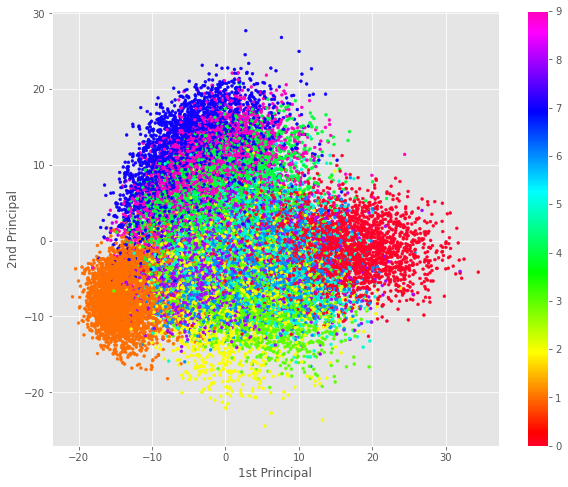

In [0]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

pca = PCA(2)
proj = pca.fit_transform(encoded_train)
plt.scatter(proj[:30000, 0], proj[:30000, 1],c=y_train[:30000], s=8, cmap='gist_rainbow')
plt.xlabel('1st Principal')
plt.ylabel('2nd Principal')
plt.colorbar()
plt.savefig('./encoded_train_vis.png')
plt.show()

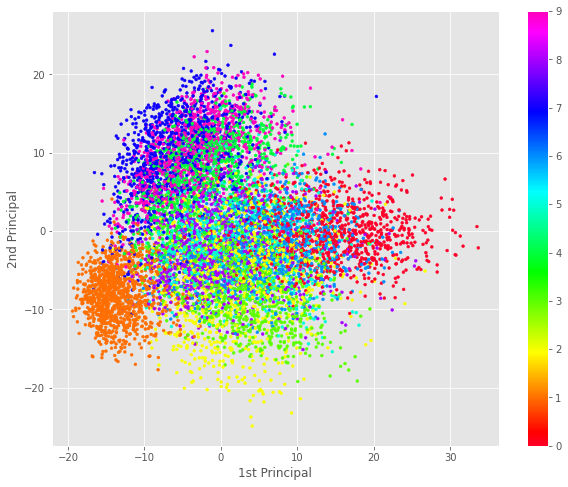

In [0]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

pca = PCA(2)
proj = pca.fit_transform(encoded_test)
plt.scatter(proj[:, 0], proj[:, 1],c=y_test[:], s=8, cmap='gist_rainbow')
plt.xlabel('1st Principal')
plt.ylabel('2nd Principal')
plt.colorbar()
plt.savefig('./encoded_test_vis.png')
plt.show()

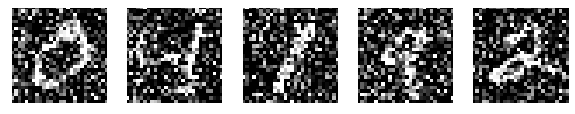

In [0]:
n = 5
plt.figure(figsize=(10, 8))
for i in range(1,n+1):
    # ax = plt.subplot(1, n, i)
    # plt.imshow(encoded_train[i].reshape(4, 4 * 8).T, cmap='Blues')
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)

    ax = plt.subplot(1, n, i)
    plt.imshow(np.squeeze(x_train_noisy[i],axis=-1))

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('./en2_train_vis.png')
plt.show()

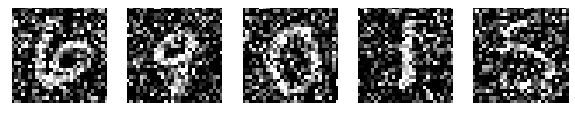

In [0]:
n = 5
x = 10
plt.figure(figsize=(10, 8))
for i in range(1,n+1):
    # ax = plt.subplot(1, n, i)
    # plt.imshow(encoded_test[i+x].reshape(4, 4 * 8).T, cmap='Blues')
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)

    ax = plt.subplot(1, n, i)
    plt.imshow(np.squeeze(x_test_noisy[i+x],axis=-1))

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('./en2_test_vis.png')
plt.show()

In [0]:
outputs = None
# loop over our number of output samples
for i in range(0, 100):
	# grab the original image and reconstructed image
	original = (x_test_noisy[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")
	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])
	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output
	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])
# save the outputs image to disk
cv2.imwrite('./output.png', outputs)

True

In [0]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
palette = sns.color_palette("bright", 10)

# X, y = load_digits(return_X_y=True)
# print(X.shape, y.shape)

tsne = TSNE(n_components=2, random_state=0)

embedded = tsne.fit_transform(encoded_train)
# hist = sns.scatterplot(X_embedded[:500,0], X_embedded[:500,1], hue=y_train[:500], legend='full', palette=palette)
plt.scatter(embedded[:10000, 0], embedded[:10000, 1],c=y_train[:10000], s=8, cmap='tab10')
plt.xlabel('Dim_2')
plt.ylabel('Dim_1')
plt.colorbar()
plt.show()
# plt.xlabel('Dim_2')
# Set y-axis label
# plt.ylabel('Dim_1')
# fig = hist.get_figure()
# fig.savefig('./tsne_mnist.png')

Text(0, 0.5, 'P(x)')

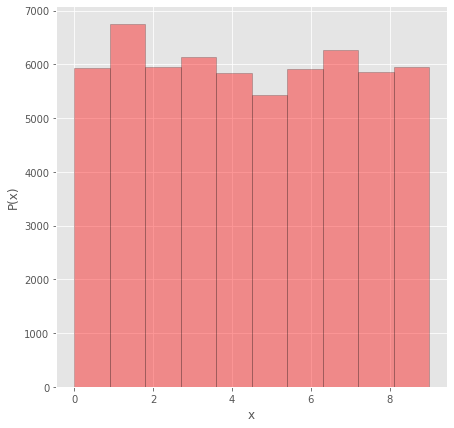

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')
plt.figure(figsize=[7,7])

x_train_noise = np.random.normal(loc=0.0, scale=0.5, size=(60000,))
hist1 = sns.distplot(y_train, hist=True, kde=False, color='Red', bins=10, hist_kws={'edgecolor':'black'})
# hist2 = sns.kdeplot(x_train_noise, shade=True, color='red')
# Add labels
plt.xlabel('x')
plt.ylabel('P(x)')
# fig = hist2.get_figure()
# fig.savefig('./gaussian.png')

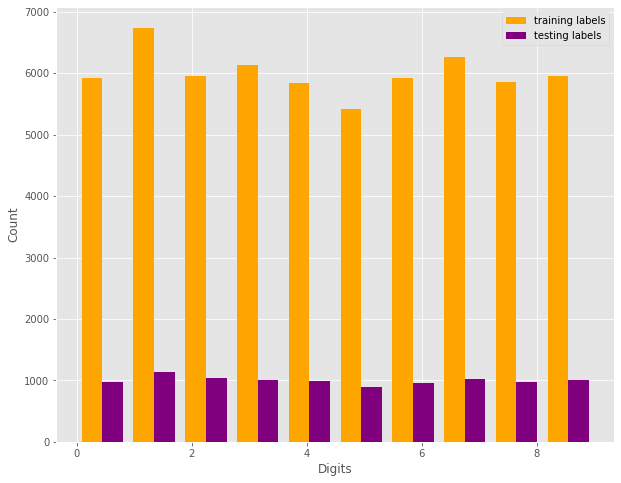

In [0]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')
hist = plt.hist([y_train, y_test], color=['orange', 'purple'], bins=10)
plt.legend(['training labels', 'testing labels'], loc='best')
plt.xlabel('Digits')
plt.ylabel('Count')
plt.savefig('./histogram_mnist3.png')
plt.show()


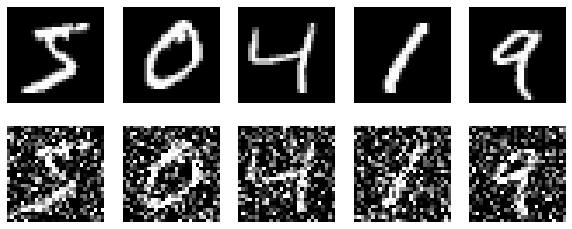

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig = plt.figure(figsize=[10,4])

for i, j in zip(range(1, 6), range(6, 11)):
  plt.subplot(2, 5, i)
  plt.axis('off')
  plt.grid(b=False)
  plt.imshow(np.squeeze(x_train[i-1], axis=-1), cmap=plt.get_cmap('gray'))

  plt.subplot(2, 5, j)
  plt.axis('off')
  plt.grid(b=False)
  plt.imshow(np.squeeze(x_train_noisy[j-6], axis=-1), cmap=plt.get_cmap('gray'))

plt.show()